# Run a Watershed

This Notebook covers running a calibrated NEWT model for a selected watershed.

In [1]:
import pandas as pd
import pandas.plotting as pdp
import numpy as np
import matplotlib.pyplot as plt
import dataretrieval.nwis as nwis
import pynldas2 as nldas
import s3fs
import zarr
import xarray as xr
import rioxarray as rio
import cartopy.crs as ccrs
import metpy
import os
import warnings
import subprocess
import geopandas
from pynhd import NLDI
from NEWT import Watershed, perf_summary, NextBmi
import NEWT.datatools as datatools

In [11]:
sagehen = "10343500"
eagle = "394220106431500"
sopl = "06711565"
ws = sagehen

In [7]:
use_origin = True
if use_origin:
    raw = pd.read_csv(r"X:\Rio.Data\StreamTemperature\NEXT\ReadyData\daymet_aoi\USGS-" + f"{ws}.csv")
    raw["date"] = pd.to_datetime(raw["datetime"]).dt.date
    raw = raw.set_index(["date", "variable"])["mean"].unstack(1)[["tmax", "prcp", "vp", "srad"]]
else:
    raw = pd.read_csv("AllData.csv", dtype={"id": "str"})
    raw = raw[raw["id"] == ws]
    raw["date"] = pd.to_datetime(raw["date"]).dt.date
    raw = raw.set_index("date")[["tmax", "prcp", "vp", "srad"]]
raw

variable,tmax,prcp,vp,srad
date,,,,
2000-01-01,4.228093,2.524294,264.43994,246.16473
2000-01-02,-0.979243,2.385266,208.36285,230.75398
2000-01-03,-6.563536,0.006947,169.97153,219.51863
2000-01-04,2.412611,0.708189,132.80255,322.61646
2000-01-05,-1.357083,0.000000,200.22783,266.28244
...,...,...,...,...
2022-12-27,9.523977,0.013607,405.59888,245.29948
2022-12-28,5.746067,12.246856,441.03708,173.26007
2022-12-29,-2.659505,0.071853,262.26163,196.92491


### ngen Setup

In [8]:
# Side note: write forcing for ngen.
loc_name = ws
data = raw.reset_index()[["date", "tmax"]].rename(columns={"date": "time", "tmax": "land_surface_air__temperature"})
data["time"] = pd.to_datetime(data["time"]).dt.strftime("%Y-%m-%d %H:%M:%S")
data.to_csv(loc_name + ".csv", index=False)

In [10]:
# Generate hydrofab subset
subprocess.run(["hfsubset.exe", "-o", f"./{ws}.gpkg", "-l", "divides,nexus", "-t", "nldi", f"nwissite:USGS-{ws}"], capture_output=True)

CompletedProcess(args=['hfsubset.exe', '-o', './06711565.gpkg', '-l', 'nexus', '-t', 'nldi', 'nwissite:USGS-06711565'], returncode=1, stdout=b'\x1bhfsubset\x1b \x1b==>\x1b 12:24:54 verified hfsubset endpoint https://www.lynker-spatial.com/hydrofabric/hfsubset/ (version 1.1.1)\n\x1bhfsubset\x1b \x1b==>\x1b 12:24:54 GET /subset?identifier=nwissite%3AUSGS-06711565&identifier_type=nldi&layer=nexus&subset_type=reference&version=2.2&weights=\n\x1bhfsubset\x1b \x1b==>\x1b 12:25:03 failed to complete hfsubset request: hfsubset service returned status 500 Internal Server Error\n', stderr=b'')

In [38]:
gp = geopandas.read_file(f"{ws}.gpkg")

In [39]:
gp

,divide_id,areasqkm,has_flowline,id,vpuid,geometry
0,8933508.0,0.834302,True,8933508.0,16,"POLYGON ((-2047364.998 2085165.001, -2047364.9..."
1,8933512.0,0.824848,True,8933512.0,16,"POLYGON ((-2047364.998 2085165.001, -2047005.0..."
2,8933522.0,0.191251,True,8933522.0,16,"POLYGON ((-2045235.004 2084865.001, -2045235.0..."
3,8933524.0,0.252900,True,8933524.0,16,"POLYGON ((-2046134.998 2085464.996, -2045235.0..."
4,8933520.0,0.120152,True,8933520.0,16,"POLYGON ((-2046135.000 2085494.995, -2045715.0..."
5,8934344.0,0.334801,True,8934344.0,16,"POLYGON ((-2046225.001 2085314.997, -2046164.9..."
6,8933496.0,1.326148,True,8933496.0,16,"POLYGON ((-2048175.001 2086484.998, -2048025.0..."
7,8933582.0,5.248346,True,8933582.0,16,"POLYGON ((-2050664.995 2084835.004, -2050665.0..."
8,8933608.0,3.187798,True,8933608.0,16,"POLYGON ((-2046824.998 2082854.996, -2046644.9..."
9,8933600.0,1.763548,True,8933600.0,16,"POLYGON ((-2047094.996 2083394.998, -2046945.0..."


### General Run

In [4]:
stdat = nwis.get_dv(sites=[ws], start="2000-01-01", end="2022-12-31", parameterCd="00010")[0].assign(date=lambda x: x.index.date)[["date", "00010_Mean"]].rename(columns={"00010_Mean": "temperature"}).set_index("date").dropna()
# stdat

In [5]:
# Optional: add streamflow
qdat = nwis.get_dv(sites=[ws], start="2000-01-01", end="2022-12-31", parameterCd="00060")[0].assign(date=lambda x: x.index.date)[["date", "00060_Mean"]].rename(columns={"00060_Mean": "Q"}).set_index("date").dropna()
# qdat

In [6]:
data = stdat.merge(raw, on="date").merge(qdat, on="date")
data["date"] = pd.to_datetime(data.index).normalize()
data.index = range(len(data))
# data

In [7]:
cut = round(len(data) * 0.7)
cal = data.iloc[:cut,:].copy()
val = data.iloc[cut:,:].copy()
print(f"Cal: {min(cal['date'].dt.date)} - {max(cal['date'].dt.date)} | Val: {min(val['date'].dt.date)} - {max(val['date'].dt.date)}")

Cal: 2006-04-29 - 2018-01-09 | Val: 2018-01-10 - 2022-12-31


In [8]:
model = Watershed.from_data(cal, threshold_engine=True)

In [9]:
pred = model.run_series(val)

In [10]:
pred

,temperature,tmax,prcp,vp,srad,Q,date,actemp,anom,temp.mod
0,-0.0,2.277873,5.945569,329.18585,204.901550,93.2,2018-01-10,-0.593050,0.016471,0.0
1,-0.0,-5.206417,4.741279,253.18044,152.600330,84.1,2018-01-11,-0.581879,-0.000121,0.0
2,0.0,-2.603880,8.975293,327.22153,123.444466,83.4,2018-01-12,-0.568290,-0.000619,0.0
3,0.1,-0.932367,0.000000,281.77365,253.332210,80.9,2018-01-13,-0.552304,0.024323,0.0
4,0.3,1.923767,0.000000,293.54333,299.733980,82.8,2018-01-14,-0.533942,0.232227,0.0
...,...,...,...,...,...,...,...,...,...,...
1811,0.0,4.154530,10.553032,424.24790,191.490330,91.6,2022-12-27,-0.486420,0.000000,0.0
1812,0.0,0.119703,8.184340,298.54263,210.258450,89.7,2022-12-28,-0.510714,0.000000,0.0
1813,0.0,-7.772742,1.973018,180.07483,218.128270,88.3,2022-12-29,-0.532402,0.000000,0.0
1814,0.0,-4.506784,7.100912,182.08226,229.409400,88.8,2022-12-30,-0.551493,-0.000000,0.0


In [11]:
perf_summary(pred)

,R2,RMSE,NSE,Pbias,Bias,MaxMiss
0,0.918526,1.720646,0.91714,2.02869,0.144535,0.851662


In [34]:
pred["day"] = pred["date"].dt.day_of_year
pred["obs_grad"] = np.gradient(pred["temperature"])
pred["mod_grad"] = np.gradient(pred["temp.mod"])
pred_anom = pred.set_index("date").groupby("day")[["tmax", "vp", "prcp", "Q", "srad", "obs_grad", "mod_grad"]].transform(lambda x: x - x.mean()).rolling(365, center=False).mean()

For Eagle River, all major unmodeled temperature spikes correspond to sustained low flows (30-day mean), but not to any consistent air temperature pattern at the time, and precipitation and solar radiation show no effect.  Both temperature spikes did correspond to a large and sustained positive air temperature anomaly around the end of the previous calendar year, which could cause the low flows (snow melting off early or falling as rain).  Both do correspond to a similarly-shaped air temperature spike, but disproportionately, and in the 2021 spike there is a substantial lag between the air temperature and water temperature spikes.  At a longer timescale, the persistent relationship is in a hot winter and low-flow summer.  This consistently suggests that the missed spike is indeed seasonal in character.  How about if we add the gradient?

The gradients are noisy, but we do see that the model is consistently underestimating the temperature gradients.  This is sustained during the heat waves, but true across the board.  Possibly there is a nonlinear air temperature response that is being missed as well?

Threshold response testing with Eagle River:

- No threshold: R2 0.94, RMSE 1.52, max-miss 3.5; simply underestimates some peaks (in 2018, 2021, 2022), but completely misses others (2018, 2022)
- Threshold: R2 0.93, RMSE 1.55, max-miss 3.0; does a better job in 2018 and 2021, but still entirely misses or vastly underestimates some peaks - probably some proxy for a dry year is strictly necessary.  Maybe in certain years we should simply "stretch" seasonality relative to the mean?
- Air temperature-based threshold: R2 0.92, RMSE 1.7, max-miss 0.85!  Worse performace and tends to overestimate summer swings, but does much better at catching high temperatures.  Possibly a useful option, but not a good default.

Back to seasonality: the two hot years with significant lead-up data do show low precipitation in the preceding winter-to-spring period, but it's a bit too close in 2022 to explain it (doesn't look like a lack of *snow*).  Interestingly, an anomalously cold year the model doesn't catch (2019) followed an average winter but a quite wet spring.  Aggregating to a full year (right-aligned), we see that 2019 (cool) followed a wet period, 2020 (average) was average, 2021 (hot) was very dry, and 2022 (hot) was about average but coming out of a dry spell.

Now, looking at a cumulative sum of precipitation anomaly, that point is emphasized. 2022 wasn't terribly dry itself, but was very much still digging itself out of the dry spell.  This can be seen using a 730-day rolling mean.  It would probably also work to employ the 365-day mean around late April, which is a convenient time because the temperature should be about average then.  Let's try running it with a season engine.

- One-year precip: R2 0.94, RMSE 1.50, max-miss 2.6 C!  Getting better. Qualitatively, it now does a bit better in 2021 and 2022, with a reduced overestimate in 2019. However, it now overestimates 2019/20 winter temperatures.

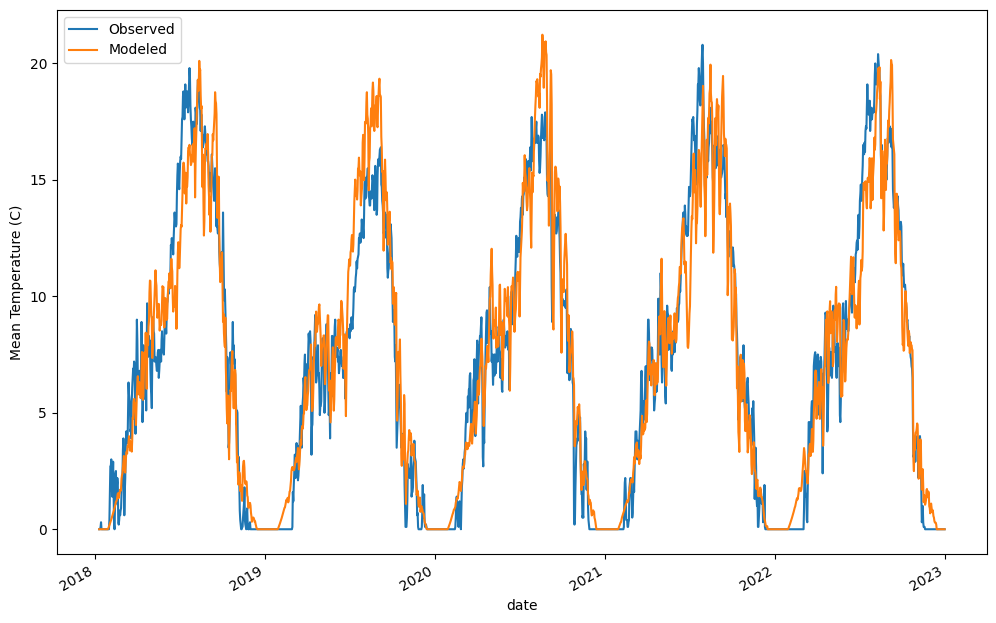

In [12]:
fig = plt.figure(figsize=(12, 8))
ax = plt.axes()
# fig, axes = plt.subplots(2, 1, figsize=(12,9), sharex=True)
# ax = axes[0]
pred.plot(x="date", y="temperature", label="Observed", ax=ax)
pred.plot(x="date", y="temp.mod", label="Modeled", ax=ax)
# ax.set_xlabel("Date")
ax.set_ylabel("Mean Temperature (C)")
# _ = ax.set_title("Eagle River")
# pred_anom.plot(y="prcp", ax=axes[1])
# axes[1].set_ylabel("Precipitation Anomaly (mm/day)")
# _ = axes[-1].set_xlabel("Date")
fig.savefig("results/EagleCalibratedThresholdAT.png")

## BMI Version

Let's try this with the BMI.  We'll export the calibrated model above, then use it to run the validation period.

It works!  Awesome.

In [11]:
file = f"model{ws}.yaml"
model.date = val["date"].iloc[0]
model.to_file(file)  # Note: with numpy arrays and stuff, the serialization is bizarre but it works

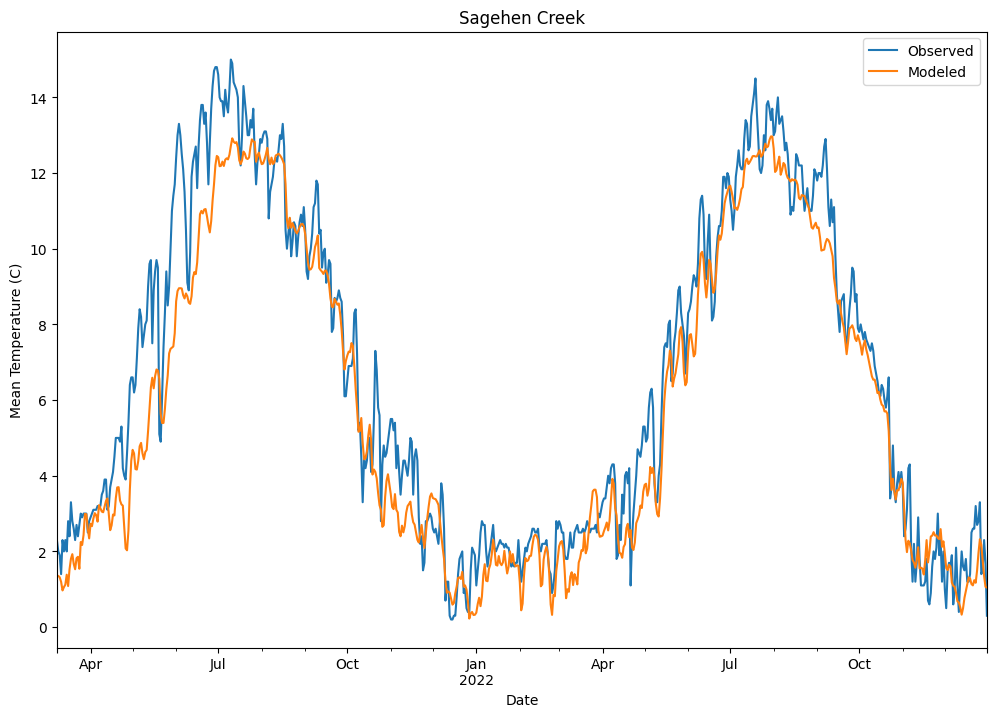

In [12]:
# First, make sure file I/O works
mod2 = Watershed.from_file(file)
pred = mod2.run_series(val)
fig = plt.figure(figsize=(12, 8))
ax = plt.axes()
pred.plot(x="date", y="temperature", label="Observed", ax=ax)
pred.plot(x="date", y="temp.mod", label="Modeled", ax=ax)
ax.set_xlabel("Date")
ax.set_ylabel("Mean Temperature (C)")
_ = ax.set_title("Sagehen Creek")

In [13]:
# Now, do it with BMI.
bmi = NextBmi()
bmi.initialize(file)

In [14]:
bmi._model.date

Timestamp('2021-03-08 00:00:00')

In [15]:
at = bmi.get_input_var_names()
st = bmi.get_output_var_names()[0]
def runner(mod, row):
    mod.set_value(at, np.array([row.tmax]))
    # mod.set_value(vp, np.array([row.vp]))
    mod.update()
    return mod.get_value(st, np.array([1.0]))[0]

In [16]:
bpr = val.copy()
bpr["temp.mod"] = [runner(bmi, row) for row in bpr.itertuples()]

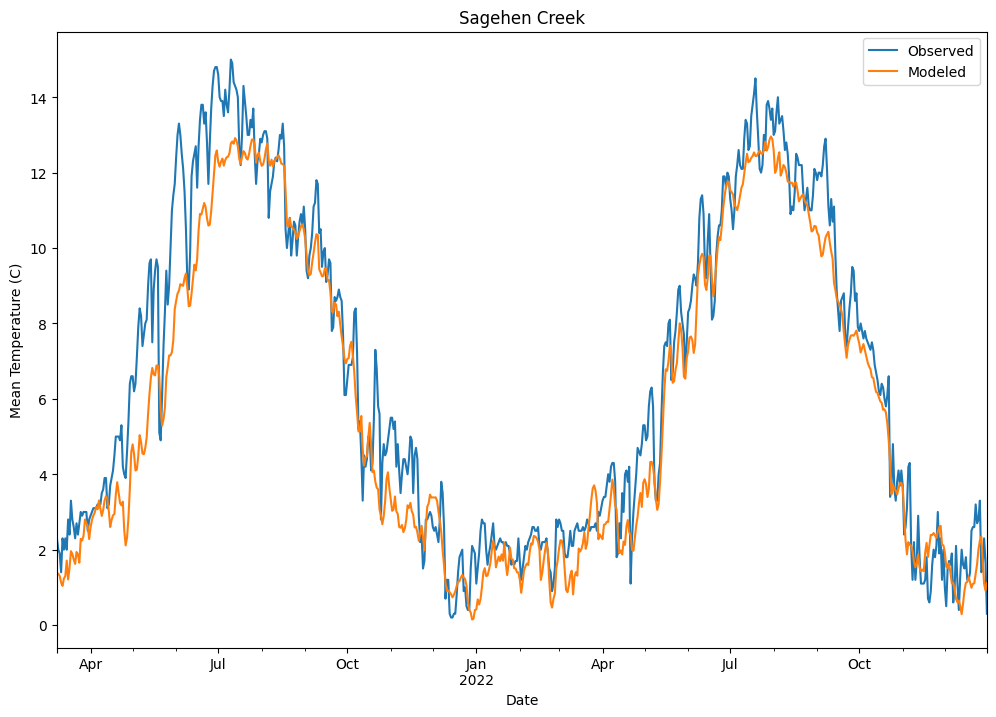

In [17]:
fig = plt.figure(figsize=(12, 8))
ax = plt.axes()
bpr.plot(x="date", y="temperature", label="Observed", ax=ax)
bpr.plot(x="date", y="temp.mod", label="Modeled", ax=ax)
ax.set_xlabel("Date")
ax.set_ylabel("Mean Temperature (C)")
_ = ax.set_title("Sagehen Creek")

# Near-Real Time

In my use case, daymet data runs through 2022.  After that, switch to using more recent data.  In this test, climatology is *not* adjusted.  We can use NLDAS data to fill in the gaps and get very recent.

In [4]:
nldi = NLDI()
basin = nldi.get_basins(ws)
geo = basin.geometry.iloc[0]

<Axes: >

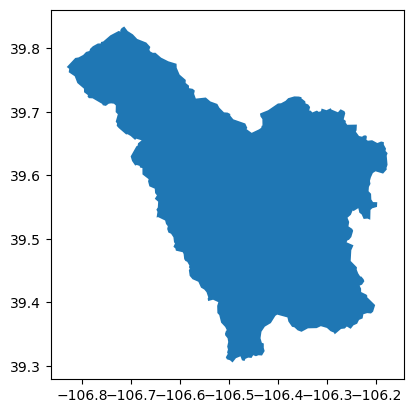

In [5]:
basin.plot()

In [6]:
rt_tmax = datatools.get_nldas(geo, "temp", "tmax", "2023-01-01", "2024-07-30")
rt_tmax

/home/jovyan/newt-proto/src/NEWT/datatools.py:37: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  groupby("time").map(lambda x: x.mean()).to_dataframe()


,tmax
date,
2023-01-01,0.390455
2023-01-02,-1.632727
2023-01-03,-6.146364
2023-01-04,-8.234091
2023-01-05,-1.137273
...,...
2024-07-26,21.575000
2024-07-27,19.975455
2024-07-28,19.270909


In [ ]:
data_now = nwis.get_dv(sites=[ws], start="2023-01-01", end="2024-07-20", parameterCd="00010")[0].assign(date=lambda x: x.index.date)[["date", "00010_Mean"]].rename(columns={"00010_Mean": "temperature"}).set_index("date").dropna().merge(rt_tmax, on="date")
data_now["date"] = pd.to_datetime(data_now.index)
data_now = pd.concat([val[["temperature", "tmax", "date"]], data_now])
data_now.index = range(len(data_now))
data_now

In [84]:
prd_now = model.run_series(data_now)

In [85]:
perf_summary(prd_now)

,R2,RMSE,NSE,Pbias,Bias,MaxMiss
0,0.937969,1.468306,0.936582,-1.077893,-0.0751,3.522854


<Axes: xlabel='date'>

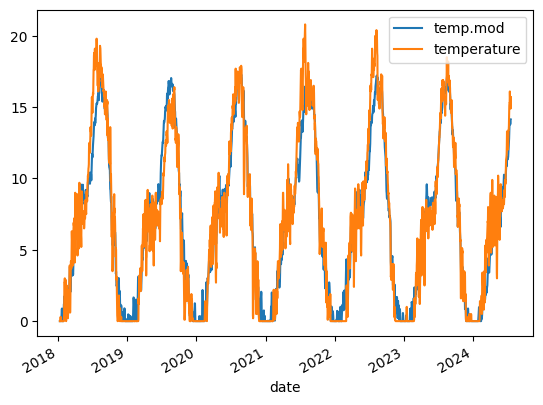

In [86]:
ax = prd_now.plot(x="date", y="temp.mod")
prd_now.plot(x="date", y="temperature", ax=ax)

# Forecast

See: https://mesowest.utah.edu/html/hrrr/zarr_documentation/html/zarr_HowToDownload.html

Wherein we download zarr-format HRRR data and run an actual forecast.  Starting at GMT 0600 means the first 24 hours capture most of the day for all of the CONUS and we can use that for a decent estimate at daily tmax.

## Full Forecast Run

Trail a model on the full available dataset (through 2022), then run a (re)forecast at 48-hour lead time for 2023-24.  How does that work with two-day forecasts?  Day-0 temperature is actually ignored, so we use the day-1 (24-48 hour) forecast for the data source, then set air temperature to zero for the last day (i.e., two days from "now").  Compute performance for the data-coverage period and make a note of forecasted temperatures.

In [4]:
rerun = False
file = f"results/weather_forecast_{ws}.csv"
today = np.datetime64("today")
strify = lambda date: "".join(str(date).split("-"))[:8]

In [ ]:
geo = datatools.get_shape_usgs(ws)
mod = Watershed.from_data(data)
obs = nwis.get_dv(sites=[ws], start="2023-01-01", end=str(today), parameterCd="00010")[0].assign(date=lambda x: x.index.date)[["date", "00010_Mean"]].rename(columns={"00010_Mean": "temperature"}).set_index("date").dropna()
obs.index = pd.to_datetime(obs.index)

NameError: name 'data' is not defined

In [62]:
# lambda date: datatools.forecast_areal_summary(datatools.forecast_watershed_clip(datatools.get_daily_forecasts(strify(date), var="TMP"), geo), "tmax")["tmax"].iloc[1]
def get_data(date):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        try:
            st = strify(date)
            print(st, end=" ")
            return datatools.forecast_areal_summary(
                datatools.forecast_watershed_clip(
                    datatools.get_daily_forecasts(st, var="TMP"), geo), "tmax")["tmax"].iloc[1]
        except:
            return np.NaN

def run_wfr():
    run_dates = np.arange(np.datetime64("2023-01-01"), np.datetime64("today") + 1)
    fcst_dates = run_dates + 1
    return pd.DataFrame({"date": fcst_dates, "tmax": pd.Series(run_dates).apply(get_data)})

In [81]:
if rerun or not os.path.exists(file):
    wfr = run_wfr()
    wfr.to_csv(file, index=False)
else:
    wfr = pd.read_csv(file)
    wfr["date"] = pd.to_datetime(wfr["date"])

In [82]:
wfr = pd.concat([wfr, pd.DataFrame({
    "date": wfr["date"].iloc[-1] + np.timedelta64(1, "D"),
    "tmax": wfr["tmax"].iloc[-1]
}, index = [len(wfr)])])

In [97]:
pred = mod.run_series(wfr.dropna())
pred

,date,tmax,actemp,anom,temp.mod
0,2023-01-02,-1.416667,1.505830,-0.016889,1.488941
1,2023-01-03,0.916667,1.502431,-0.045780,1.456652
2,2023-01-04,2.833333,1.499441,-0.061656,1.437786
3,2023-01-05,1.666667,1.496831,-0.097096,1.399735
4,2023-01-06,0.250000,1.494570,-0.256378,1.238192
...,...,...,...,...,...
579,2024-08-07,35.166668,12.256327,1.538549,13.794876
580,2024-08-08,35.416668,12.198995,1.606079,13.805075
581,2024-08-09,34.666668,12.138362,1.643187,13.781549
582,2024-08-10,34.000000,12.074496,1.657137,13.731633


As of August 9, 2024, the Sagehen (re)forecasts for mean temperature are:

- August 9: 13.8 C (1.6 C above mean)
- August 10: 13.7 C (1.7 C above mean)
- August 11: 13.5 C (1.5 C above mean)

In [98]:
compare = pred.merge(obs, on="date", how="left")
perf_summary(compare)

,R2,RMSE,NSE,Pbias,Bias,MaxMiss
0,0.942694,1.244588,0.907678,8.1793,0.436093,0.287409


### Forecast Check

In [8]:
nwis.get_dv(sites=[ws], start=str(today-7), end=str(today), parameterCd="00010")[0].assign(date=lambda x: x.index.date)[["date", "00010_Mean"]].rename(columns={"00010_Mean": "temperature"}).set_index("date").dropna()

,temperature
date,
2024-08-06,13.1
2024-08-07,12.9
2024-08-08,12.6
2024-08-09,12.6
2024-08-10,12.2
2024-08-11,11.4
2024-08-12,11.5


For calibrated forecast 1 (Sagehen, August 9-August 11, run on August 9):

- 8/9: observed 12.6 C, forecast 13.8 C
- 8/10: 12.2, 13.7
- 8/11: 11.4, 13.5

### Plot

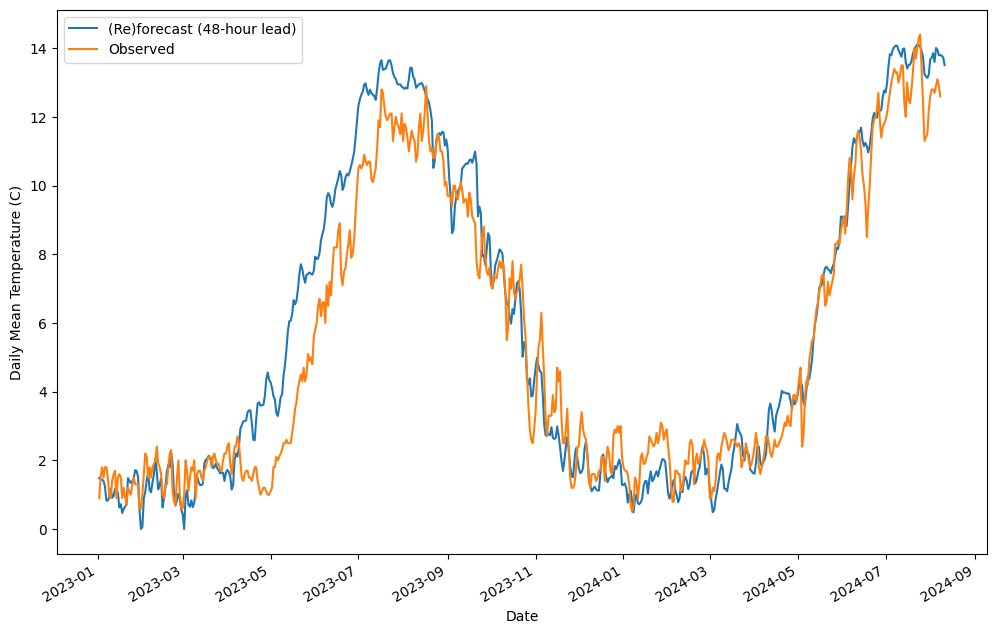

In [99]:
fig = plt.figure(figsize=(12, 8))
ax = plt.axes()
compare.plot(x="date", y="temp.mod", label="(Re)forecast (48-hour lead)", ax=ax)
compare.plot(x="date", y="temperature", label="Observed", ax=ax)
ax.set_xlabel("Date")
ax.set_ylabel("Daily Mean Temperature (C)")
plt.savefig("results/SagehenCalibratedForecast.png")

## Pull Forecast Data

C:\Users\dphilippus\OneDrive - Colorado School of Mines\PhD\NEXT\newt\src\NEWT\datatools.py:66: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds["time"] = (ds["time"] - np.timedelta64(6, 'h')).astype("datetime64[D]")  # approximate, but gets it to the right day-ish


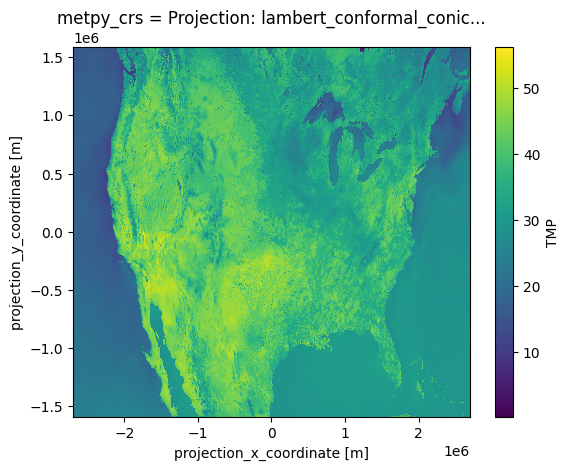

In [7]:
geom = datatools.get_shape_usgs(ws)
tmax = datatools.get_daily_forecasts("20240801", var="TMP")
tmax[0,:,:].plot()

This part seems to be mysteriously crashing when I try to extract it, but the same code worked before.  I'm going to see if it's a server issue and try running it on desktop.

Confirmed: this causes a mysterious kernel crash on 2i2C, but runs fine on desktop.

## Clip to Watershed

In [8]:
clip = datatools.forecast_watershed_clip(tmax, geom)

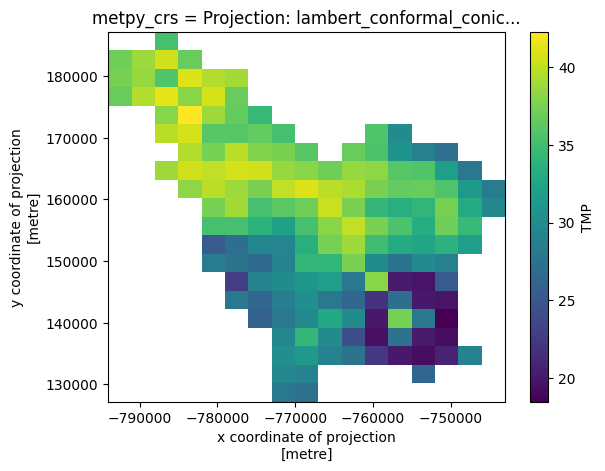

In [10]:
clip[0,:,:].plot()

## Compute Areal Means

In [39]:
temps = datatools.forecast_areal_summary(clip, "tmax")
temps["tmax"].iloc[1]

C:\Users\dphilippus\OneDrive - Colorado School of Mines\PhD\NEXT\newt\src\NEWT\datatools.py:95: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  summary = clipped_fcst.groupby("time").map(operator).to_pandas().rename(new_name)


33.125